In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from RobustRandomForest import RobustRandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm

# Класс-Распределение для создания выборки с выбросами

In [2]:
class Distribution():

    def __init__(self, alpha: float = 0.95, ro1: float = 0.05, ro2: float = 0.5, _func = None):

        self.alpha = alpha
        self.ro1 = ro1
        self.ro2 = ro2

        if _func != None:
            self.func = _func
        else:
            self.func = self.__default_func

        return


    def distribution(self, borders: list[float] = [-1, 1], N: int = 100, random_state: int = np.random.randint(99999999)):

        X = np.linspace(borders[0], borders[1], N)
        y = self.func(X)

        X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=random_state)

        X_train = pd.DataFrame(data = {'X':X_train})
        X_test = pd.DataFrame({'X':X_test})

        Y_train = MaxAbsScaler().fit_transform(Y_train.reshape(-1, 1)).flatten()
        Y_train = pd.Series(Y_train)

        Y_test = MaxAbsScaler().fit_transform(Y_test.reshape(-1, 1)).flatten()
        Y_test = pd.Series(Y_test)

        c = np.sqrt(sum((Y_train - np.mean(Y_train))**2) / Y_train.shape[0])
        self.sigma1 = self.ro1 * c
        self.sigma2 = self.ro2

        for i in range(Y_train.shape[0]):
            if np.random.uniform(0, 1) < self.alpha:
                Y_train[i] += np.random.normal(0, self.sigma1)
            else:
                Y_train[i] += np.random.normal(0, self.sigma2)
                #Y_train[i] += np.random.randint(-2 * self.sigma2, 4 * self.sigma2)


        return X_train, X_test, Y_train, Y_test

    def __default_func(self, X):
        return X**2

# Пример запуска

In [31]:
dist = Distribution(_func=lambda x: x * np.sin(x), ro1=0.1, ro2=1.0, alpha=0.95)
X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)
print(dist.sigma1)

0.04843875485360486


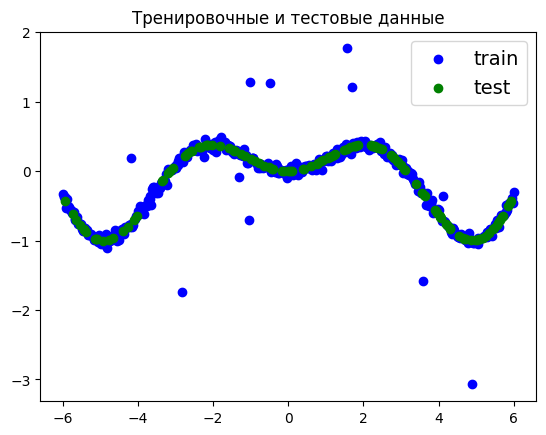

In [32]:
plt.title(f'Тренировочные и тестовые данные')
plt.scatter(X_train, Y_train, color='b', label='train')
plt.scatter(X_test, Y_test, color='g', label='test')
plt.legend(fontsize=14)
plt.show()

In [33]:
sk_rf = RandomForestRegressor(n_jobs=-1)
sk_rf.fit(X_train, Y_train)
sk_rf_pred = sk_rf.predict(X_test)
print(f'MAE sk_rf: {mean_absolute_error(sk_rf_pred, Y_test)}')
print(f'MSE sk_rf: {mean_squared_error(sk_rf_pred, Y_test)}')

MAE sk_rf: 0.060509381389013704
MSE sk_rf: 0.027244246137406034


In [34]:
huber_rrf = RobustRandomForest(n_jobs=-1, regression=True, delta=0.0005, robustness='huber')
huber_rrf.fit(X_train, Y_train)
huber_rrf_pred = huber_rrf.predict(X_test)
print(f'MAE huber_rrf: {mean_absolute_error(huber_rrf_pred, Y_test)}')
print(f'MSE huber_rrf: {mean_squared_error(huber_rrf_pred, Y_test)}')

MAE huber_rrf: 0.07346046407907914
MSE huber_rrf: 0.011752097875258546


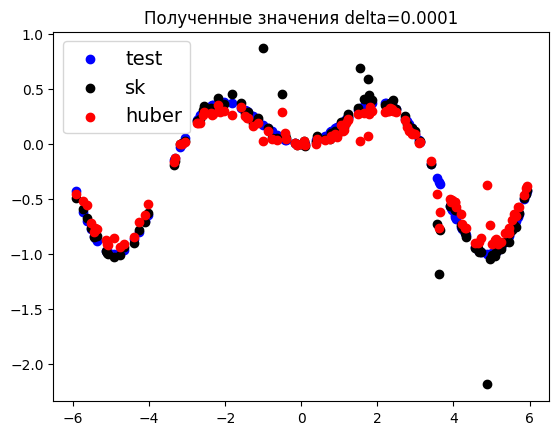

In [35]:
plt.title(f'Полученные значения delta={0.0001}')
plt.scatter(X_test, Y_test, color='b', label='test')
plt.scatter(X_test, sk_rf_pred, color='black', label='sk')
plt.scatter(X_test, huber_rrf_pred, color='r', label='huber')
plt.legend(fontsize=14)
plt.show()

In [37]:
lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
lowess_rrf.fit(X_train, Y_train, alpha=20)
lowess_rrf_pred = lowess_rrf.predict(X_test)
print(f'MAE lowess_rrf: {mean_absolute_error(lowess_rrf_pred, Y_test)}')
print(f'MSE lowess_rrf: {mean_squared_error(lowess_rrf_pred, Y_test)}')

MAE lowess_rrf: 0.05324771795736084
MSE lowess_rrf: 0.013422930829697245


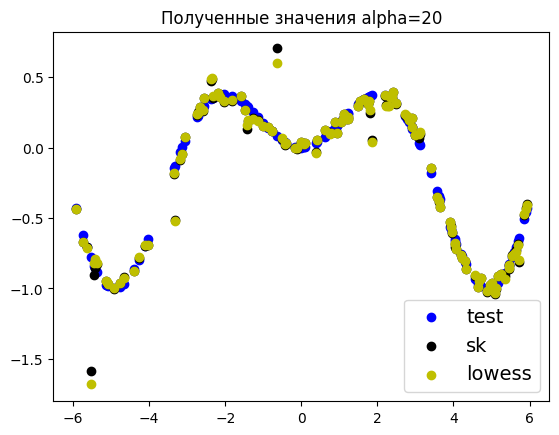

In [14]:
plt.title(f'Полученные значения alpha={20}')
plt.scatter(X_test, Y_test, color='b', label='test')
plt.scatter(X_test, sk_rf_pred, color='black', label='sk')
plt.scatter(X_test, lowess_rrf_pred, color='y', label='lowess')
plt.legend(fontsize=14)
plt.show()

# Подбираем параметр alpha

In [43]:
alphas = [0, 6, 10, 20, 50]
n = 10

In [ ]:
lowess_mae = []
lowess_mse = []

for alpha in tqdm(alphas):

    mse, mae = [], []

    for _ in range(n):
        dist = Distribution(ro1=0.1, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=alpha)
        lowess_rrf_pred = lowess_rrf.predict(X_test)

        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))

    lowess_mae.append(np.mean(mae))
    lowess_mse.append(np.mean(mse))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [18:54<00:00, 226.93s/it]


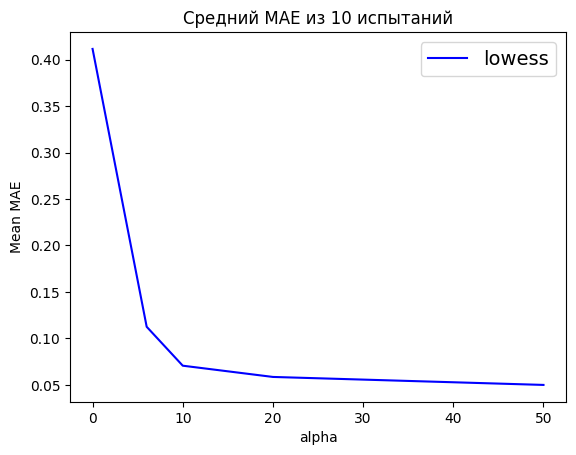

In [44]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(alphas, lowess_mae, color='b', label='lowess')
plt.xlabel('alpha')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

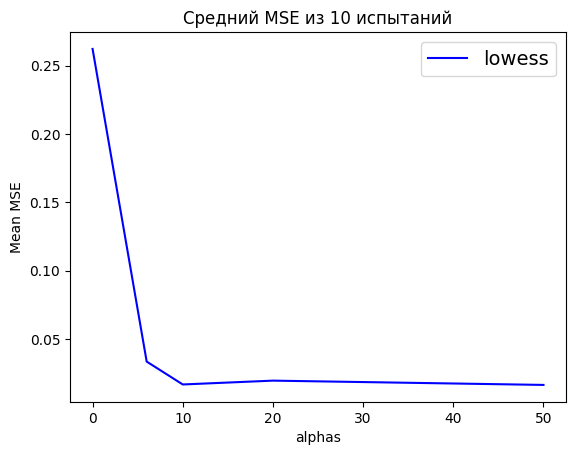

In [45]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(alphas, lowess_mse, color='b', label='lowess')
plt.xlabel('alphas')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

# Исследовние

## Списки интересующих нас переменных

In [38]:
ros = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
dims = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
alphas = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]
noise_modules = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
n = 50

## Исследовние зависимости МАЕ и MSE от меры шума 

In [39]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for ro in tqdm(ros):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(ro1=ro, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*3:3]))
    lowess_mae.append(np.mean(mae[1: n*3:3]))
    sk_mae.append(np.mean(mae[2: n*3:3]))

    huber_mse.append(np.mean(mse[0: n*3:3]))
    lowess_mse.append(np.mean(mse[1: n*3:3]))
    sk_mse.append(np.mean(mse[2: n*3:3]))

100%|██████████| 7/7 [2:58:04<00:00, 1526.42s/it]  


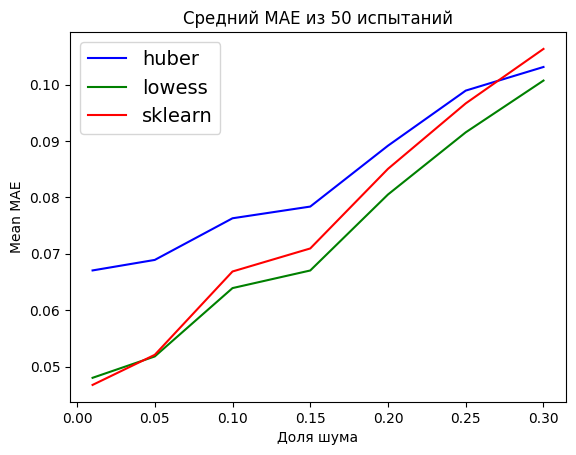

In [40]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(ros, huber_mae, color='b', label='huber')
plt.plot(ros, lowess_mae, color='g', label='lowess')
plt.plot(ros, sk_mae, color='r', label='sklearn')
plt.xlabel('Доля шума')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

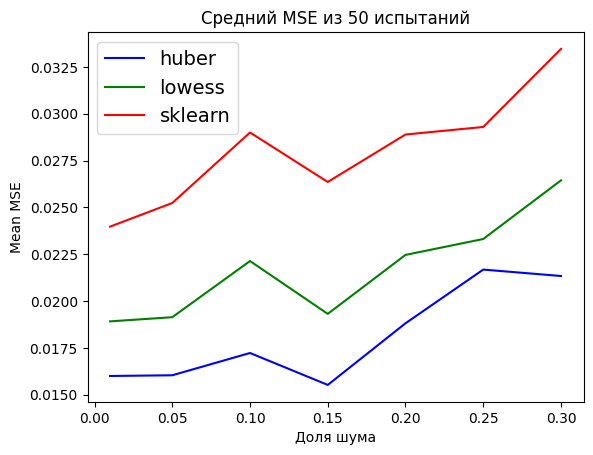

In [41]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(ros, huber_mse, color='b', label='huber')
plt.plot(ros, lowess_mse, color='g', label='lowess')
plt.plot(ros, sk_mse, color='r', label='sklearn')
plt.xlabel('Доля шума')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от размерности выборки

In [42]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for dim in tqdm(dims):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(ro1=0.1, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], dim)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*3:3]))
    lowess_mae.append(np.mean(mae[1: n*3:3]))
    sk_mae.append(np.mean(mae[2: n*3:3]))

    huber_mse.append(np.mean(mse[0: n*3:3]))
    lowess_mse.append(np.mean(mse[1: n*3:3]))
    sk_mse.append(np.mean(mse[2: n*3:3]))

100%|██████████| 10/10 [4:39:19<00:00, 1675.91s/it] 


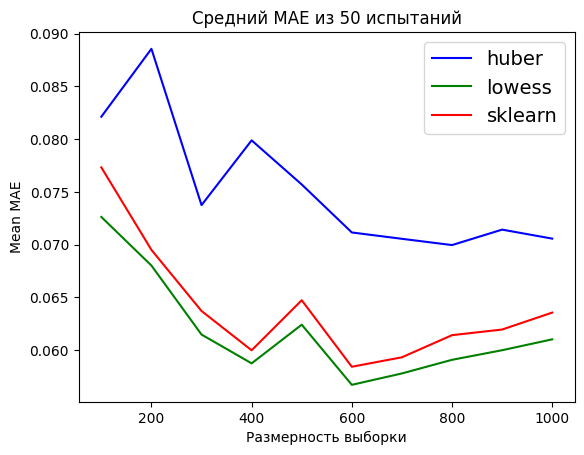

In [43]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(dims, huber_mae, color='b', label='huber')
plt.plot(dims, lowess_mae, color='g', label='lowess')
plt.plot(dims, sk_mae, color='r', label='sklearn')
plt.xlabel('Размерность выборки')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

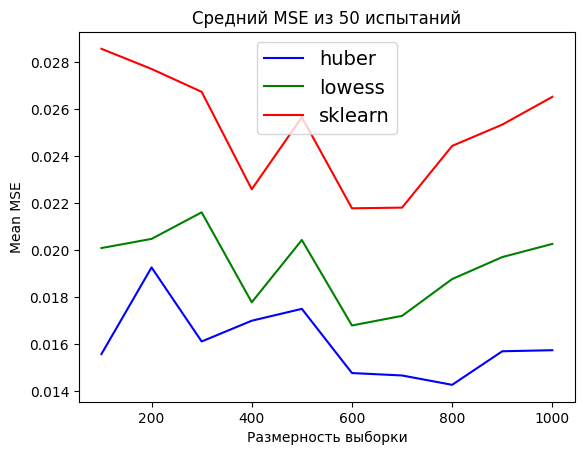

In [44]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(dims, huber_mse, color='b', label='huber')
plt.plot(dims, lowess_mse, color='g', label='lowess')
plt.plot(dims, sk_mse, color='r', label='sklearn')
plt.xlabel('Размерность выборки')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от параметра смеси

In [53]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for alpha in tqdm(alphas):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(alpha=alpha, ro2=1.0, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*3:3]))
    lowess_mae.append(np.mean(mae[1: n*3:3]))
    sk_mae.append(np.mean(mae[2: n*3:3]))

    huber_mse.append(np.mean(mse[0: n*3:3]))
    lowess_mse.append(np.mean(mse[1: n*3:3]))
    sk_mse.append(np.mean(mse[2: n*3:3]))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [4:07:41<00:00, 1486.12s/it] 


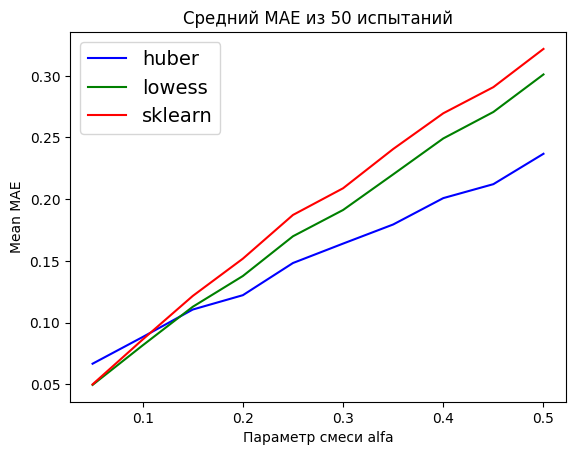

In [54]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot((1-np.array([alphas])).reshape(10,), huber_mae, color='b', label='huber')
plt.plot((1-np.array([alphas])).reshape(10,), lowess_mae, color='g', label='lowess')
plt.plot((1-np.array([alphas])).reshape(10,), sk_mae, color='r', label='sklearn')
plt.xlabel('Параметр смеси alfa')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

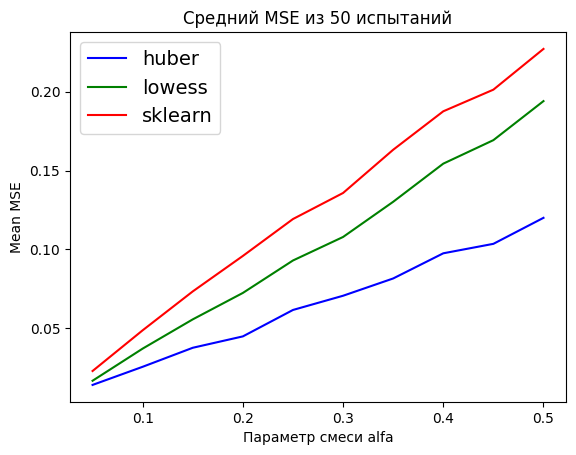

In [55]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot((1-np.array([alphas])).reshape(10,), huber_mse, color='b', label='huber')
plt.plot((1-np.array([alphas])).reshape(10,), lowess_mse, color='g', label='lowess')
plt.plot((1-np.array([alphas])).reshape(10,), sk_mse, color='r', label='sklearn')
plt.xlabel('Параметр смеси alfa')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()

## Исследовние зависимости МАЕ и MSE от модуля выбросов

In [50]:
delta = 0.0001
sk_mae, huber_mae, lowess_mae = [], [], []
sk_mse, huber_mse, lowess_mse = [], [], []

for noise_module in tqdm(noise_modules):

    mae, mse = [], []

    for i in range(n):
        
        dist = Distribution(alpha=0.9, ro2=noise_module, _func=lambda x: x * np.sin(x))
        X_train, X_test, Y_train, Y_test = dist.distribution([-6, 6], 500)

        huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='huber', delta=delta)
        huber_rrf.fit(X_train, Y_train)
        huber_rrf_pred = huber_rrf.predict(X_test)
        mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
        mse.append(mean_squared_error(huber_rrf_pred, Y_test))

        lowess_rrf = RobustRandomForest(n_jobs=-1, regression = True, robustness='lowess')
        lowess_rrf.fit(X_train, Y_train, alpha=20)
        lowess_rrf_pred = lowess_rrf.predict(X_test)
        mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
        mse.append(mean_squared_error(lowess_rrf_pred, Y_test))
        
        sk_rf = RandomForestRegressor(n_jobs=-1)
        sk_rf.fit(X_train, Y_train)
        sk_rf_pred = sk_rf.predict(X_test)
        mae.append(mean_absolute_error(sk_rf_pred, Y_test))
        mse.append(mean_squared_error(sk_rf_pred, Y_test))
    
    huber_mae.append(np.mean(mae[0: n*3:3]))
    lowess_mae.append(np.mean(mae[1: n*3:3]))
    sk_mae.append(np.mean(mae[2: n*3:3]))

    huber_mse.append(np.mean(mse[0: n*3:3]))
    lowess_mse.append(np.mean(mse[1: n*3:3]))
    sk_mse.append(np.mean(mse[2: n*3:3]))

100%|██████████| 6/6 [2:33:52<00:00, 1538.72s/it]  


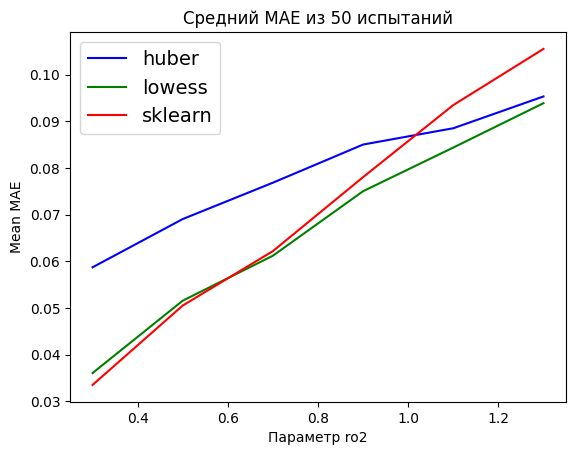

In [51]:
plt.title(f'Средний MAE из {n} испытаний')
plt.plot(noise_modules, huber_mae, color='b', label='huber')
plt.plot(noise_modules, lowess_mae, color='g', label='lowess')
plt.plot(noise_modules, sk_mae, color='r', label='sklearn')
plt.xlabel('Параметр ro2')
plt.ylabel('Mean MAE')
plt.legend(fontsize=14)
plt.show()

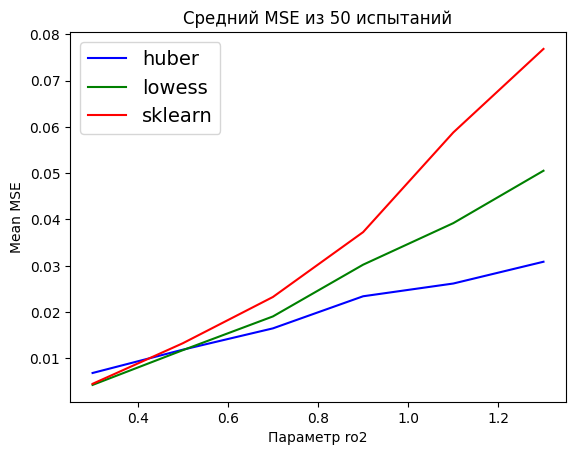

In [52]:
plt.title(f'Средний MSE из {n} испытаний')
plt.plot(noise_modules, huber_mse, color='b', label='huber')
plt.plot(noise_modules, lowess_mse, color='g', label='lowess')
plt.plot(noise_modules, sk_mse, color='r', label='sklearn')
plt.xlabel('Параметр ro2')
plt.ylabel('Mean MSE')
plt.legend(fontsize=14)
plt.show()